In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
# from dfHelper import*
import warnings
warnings.filterwarnings('ignore')

In [24]:
import numpy as np
import pandas as pd

def load_data_adl(user, run, path):
    """
    Loads the data for a given user and run.
    """

    from string import digits
    # get names for all the columns
    header = np.loadtxt(path+'/dataset/column_names.txt', delimiter='\n', dtype=str, skiprows=1)
    header = header.tolist()
    header.remove('Label columns: ')
    remove_digits = str.maketrans('', '', digits)

    header = list(map (lambda x: x.replace('Column: ', '').split(";", 1)[0].translate(remove_digits).lstrip(), header))

    data = pd.read_csv(path+f'/dataset/S{user}-ADL{run}.dat', sep=' ', header=None)
    data.columns = header

    #save a file with columns names
    import os
    if not os.path.isdir('data_cleaned'): os.mkdir('data_cleaned')
    columns = np.array(data.columns)
    np.savetxt('data_cleaned/columns_opportunity.txt', columns, fmt='%s')
    
    return data

def get_HL_activity(data, highlevel_label):
    """
    parameters:
    data: pandas dataframe
    highlevel_label: number corresponding to the highlevel activity
    """
    if not highlevel_label in {101, 102, 103, 104, 105}:
         raise ValueError('highlevel_label must be one of the following: 101, 102, 103, 104, 105')
    return data[data['HL_Activity'] == highlevel_label]

def get_HL_activity_data(data, highlevel_labels = [101, 102, 103, 104, 105]):
    """
    returns data for a given highlevel activity

    parameters:
    data: pandas dataframe
    highlevel_labels: list of numbers corresponding to the highlevel activities

    101   -   HL_Activity   -   Relaxing
    102   -   HL_Activity   -   Coffee time
    103   -   HL_Activity   -   Early morning
    104   -   HL_Activity   -   Cleanup
    105   -   HL_Activity   -   Sandwich time

    """
    if not set(highlevel_labels).issubset({101, 102, 103, 104, 105}) != len(highlevel_labels): 
        raise ValueError('highlevel_label must be one of the following: 101, 102, 103, 104, 105')

    df = data[data['HL_Activity']==highlevel_labels[0]]
    for i in range(1, len(highlevel_labels)):
        df = df.append(get_HL_activity(data, highlevel_labels[i]))
    df.reset_index(drop=True, inplace=True)

    return df
    
def get_locomotion(data, loc):
    """
    parameters:
    data: pandas dataframe
    highlevel_label: number corresponding to the highlevel activity
    """
    if not loc in {1, 2, 3, 4, 5 }: raise ValueError('loc must be one of the following: 1, 2, 3, 4, 5')
    return data[data['Locomotion'] == loc]

def get_locomotion_data(data, locs = [1, 2, 4, 5]):
    """
    returns data for a given locomotion activity
    parameters:
    data: pandas dataframe
    loc: list of numbers corresponding to the locomotion activities

    1   -   Locomotion   -   Stand
    2   -   Locomotion   -   Walk
    4   -   Locomotion   -   Sit
    5   -   Locomotion   -   Lie

    """

    if not set(locs).issubset({1, 2, 4, 5}): 
        raise ValueError('loc must be one of the following: 1, 2, 4, 5')

    df = data[data['Locomotion']==locs[0]]
    for i in range(1, len(locs)):
        df = df.append(get_locomotion(data, locs[i]))
    df.reset_index(drop=True, inplace=True)
    return df

def get_signals (data, signals):
    """
    parameters:
    data: pandas dataframe
    signals: list of columns labels (strings) for the signals
    """
    if not set(signals).issubset(set(data.columns)): 
        raise ValueError('signals must be a subset of the columns in data')
    columns_keep = [data.columns[0], *signals, *data.columns[243:]]
    return data[columns_keep]

def get_sensor_data(data, sensor_type):
    """
    Following Hanzika thesis we only study gyroscope, accelerometer and magnetometer, 
    x, y and z coordinates are combined into a single single dimension by taking the module

    parameters:
    data: pandas dataframe
    sensor_type: label of the sensors, can be "triaxial_acc", "IMU_acc", "IMU_gyro", "IMU_mag" or "all"
                 see figure at
    """

    if not sensor_type in {'triaxial_acc', 'IMU_acc', 'IMU_gyro', 'IMU_mag', 'all'}:
        raise ValueError('sensor_type must be one of the following: "triaxial_acc", "IMU_acc", "IMU_gyro", "IMU_mag", "all"')
        
    columns = np.loadtxt('data_cleaned/columns_opportunity.txt', delimiter='\n', dtype=str)

    # get the signals for the accelerometer and compute the modulus of the signals on x, y and z
    # accelerometer signals are in 1-37 columns
    if sensor_type == 'triaxial_acc' or sensor_type == 'all':
        acc_columns = columns[1:37]
        acc_data = data[acc_columns]
        for i in range(0, len(acc_data.columns)-3, 3):
            x, y, z = np.array(acc_data.iloc[:, i]), np.array(acc_data.iloc[:, i+1]), np.array(acc_data.iloc[:, i+2])

            newheader = acc_data.columns[i][:-1]+'_mod'
            df = pd.DataFrame(np.sqrt(x**2 + y**2 + z**2), columns=[newheader])
            acc_data = acc_data.join(df)
        acc_data.drop(acc_columns, axis=1, inplace=True)

    # imu signals are in 38-134 columns organized as follows:
    # (acc x, acc y, acc z, gyro y, gyro z, mag x, mag y, mag z, quaternion 1, quaternion 2, quaternion 3, quaternion 4)
    # up to 102
    if sensor_type == 'IMU_acc' or sensor_type == 'all' or sensor_type == 'IMU_gyro' or sensor_type == 'IMU_mag':
        imu_columns = columns[37:102]
        imu_data = data[imu_columns]
        for i in range(0, len(imu_columns), 13):
            #columns 
            if sensor_type == 'IMU_acc' or sensor_type == 'all':
                acccols = imu_columns[i:i+3]
                accx, accy, accz = np.array(imu_data[acccols[0]]), np.array(imu_data[acccols[1]]), np.array(imu_data[acccols[2]])
                accheader = imu_columns[i][:-1]+'_mod'
                imu_data[accheader] = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
            elif sensor_type == 'IMU_gyro' or sensor_type == 'all':
                gyrocols = imu_columns[i+3:i+6]
                gyrox, gyroy, gyroz = np.array(imu_data[gyrocols[0]]), np.array(imu_data[gyrocols[1]]), np.array(imu_data[gyrocols[2]])
                gyroheader = imu_columns[i+3][:-1]+'_mod'
                imu_data[gyroheader] = np.sqrt(np.square(gyrox) + np.square(gyroy) + np.square(gyroz))
            elif sensor_type == 'IMU_mag' or sensor_type == 'all':
                magcols = imu_columns[i+6:i+9]
                magx, magy, magz = np.array(imu_data[magcols[0]]), np.array(imu_data[magcols[1]]), np.array(imu_data[magcols[2]])
                magheader = imu_columns[i+5][:-1]+'_mod'
                imu_data[magheader] = np.sqrt(np.square(magx) + np.square(magy) + np.square(magz))

        imu_data.drop(imu_columns, axis=1, inplace=True)

    time = data['MILLISEC']
    activity_labels = data[data.columns[-7:]]
    
    if sensor_type == 'all':
        df = acc_data
        df = df.join(time)
        df = df.join(imu_data)
        df = df.join(activity_labels)
    elif sensor_type == 'triaxial_acc':
        df = acc_data
        df = df.join(time)
        df = df.join(activity_labels)
    else:
        df = imu_data
        df = df.join(time)
        df = df.join(activity_labels)
    return df

In [45]:
# we train a classsifier for each sensor

def data_split(sensor, split = 0.8):
    """
    prepare the data for each sensor classifier
    """
    subjects = [1,2,3]
    runs = [1,2,3,4,5]
    data = []
    targets = []
    lengths = []
    for subject in subjects:
        for run in runs:
            d = load_data_adl(subject, run, '../OpportunityUCIDataset')
            df_LW = get_locomotion_data(d, [2, 5])
            lie_walk = get_sensor_data(df_LW, sensor)
            lie = lie_walk[lie_walk['Locomotion'] == 2]
            walk = lie_walk[lie_walk['Locomotion'] == 5]
            lie = lie[lie.columns[:-7]]
            walk = walk[walk.columns[:-7]]
            lie = lie.dropna()
            walk = walk.dropna()
            if len(lie)==0 or len(walk)==0:
                continue

            lengths.append(len(lie))
            lengths.append(len(walk))

            for c in lie.columns:
                data.append(lie[c].values)
                targets.append(-1)
            for c in walk.columns:
                data.append(walk[c].values)
                targets.append(1)
    #cut legth of data to the same length
    min_length = min(lengths)
    for i in range(len(data)):
        data[i] = data[i][:min_length]

    train_data = data[:int(len(data)*split)]
    test_data = data[int(len(data)*split):]
    train_targets = targets[:int(len(targets)*split)]
    test_targets = targets[int(len(targets)*split):]

    return train_data, test_data, train_targets, test_targets

In [63]:
from tsai.all import *

def train_model (X, y, filename):
    batch_tfms = TSStandardize()
    if not os.path.isdir('models'): 
        os.mkdir('models')
    clf = TSClassifier(X, y,  path='models', arch=MLP, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
    clf.fit_one_cycle(1000, 1e-5)
    clf.export(filename+".pkl")

In [60]:
sensor = ["triaxial_acc", "IMU_acc", "IMU_gyro", "IMU_mag"]
train_data, test_data, train_targets, test_targets = data_split(sensor[0])

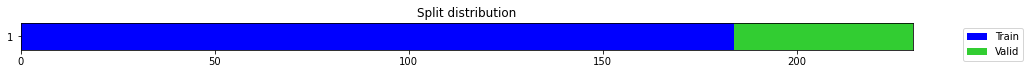

epoch,train_loss,valid_loss,accuracy,time
0,0.696009,0.692193,0.521739,00:00
1,0.695332,0.692194,0.521739,00:00
2,0.693917,0.692194,0.521739,00:00
3,0.693657,0.692193,0.521739,00:00
4,0.692927,0.692192,0.521739,00:00
5,0.691361,0.692191,0.521739,00:00
6,0.691968,0.692191,0.521739,00:00
7,0.692196,0.692191,0.521739,00:00
8,0.693102,0.692189,0.521739,00:00
9,0.692534,0.692188,0.521739,00:00


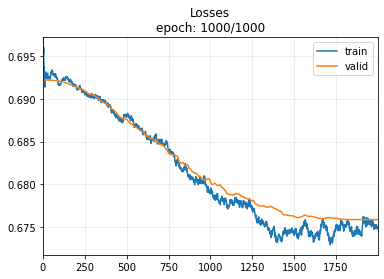

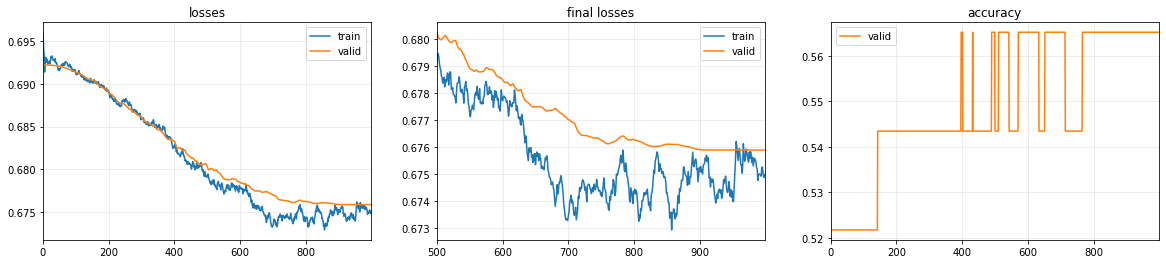

In [64]:
train_model (train_data,train_targets, str(sensor[0]))